<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/Vikas_M8_NB_MiniProject_3_BitCoin_Forecasting_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPCI Upskilling - Data Science and Engineering Track

## A program by IISC and TalentSprint

### Playground Challenge 4: BitCoin_Forecasting_ARMA [20 points]


##<b><font color="red">Please run this solution notebook on your Google Colab T4 GPU runtime</font></b>

To select the T4 GPU, follow these steps:

Runtime >> Change runtime type >> T4 GPU >> save

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARMA model and forecast the bit coin price

## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

## Problem Statement

Perform EDA and forecast the Bitcoin price using ARMA model on timeseries (bitcoin) data.

## Grading = 20 Points

In [1]:
#@title Download Dataset
!wget -qq !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/BTC.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import itertools

### Load the data and perform EDA [4 points]

Hint: Refer to this ['Bitcoin dataset EDA'](https://cdn.iisc.talentsprint.com/CDS/Assignments/Module6/M6_SNB_MiniProject_3_BitCoin_Forecasting_ARMA_Exploratory%20Data%20Analysis.pdf)

In [3]:
# YOUR CODE HERE
df = pd.read_csv('BTC.csv')
df.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0


#### Analyze the correlation (heatmap) of all the features

In [4]:
# YOUR CODE HERE
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999412,0.998898,0.998607,0.998607,0.791723
High,0.999412,1.000000,0.998812,0.999398,0.999398,0.794166
Low,0.998898,0.998812,1.000000,0.999258,0.999258,0.785406
Close,0.998607,0.999398,0.999258,1.000000,1.000000,0.790311
Adj Close,0.998607,0.999398,0.999258,1.000000,1.000000,0.790311
Volume,0.791723,0.794166,0.785406,0.790311,0.790311,1.000000


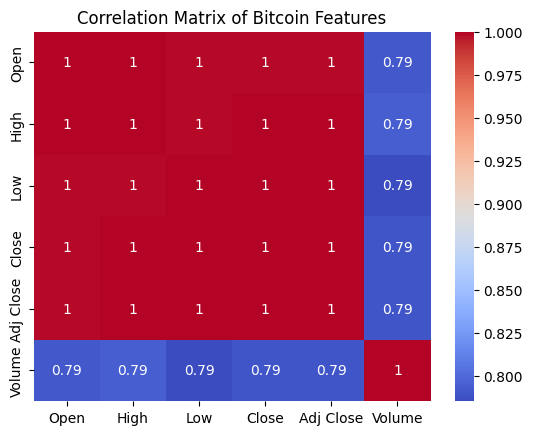

In [5]:
import seaborn as sns

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Bitcoin Features')
plt.show()

### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [6]:
# YOUR CODE HERE
# Apply first-order differencing to make the series stationary
df_cleaned = df.copy()
df_cleaned['Close_Diff'] = df_cleaned['Close'].diff().dropna()

# Perform ADF test again on the differenced series
adf_result_diff = adfuller(df_cleaned['Close_Diff'].dropna())

# Extract results
adf_output_diff = {
    "ADF Statistic": adf_result_diff[0],
    "p-value": adf_result_diff[1],
    "Critical Values": adf_result_diff[4]
}

# Display ADF test results for differenced series
adf_output_diff


{'ADF Statistic': -7.516200184052351,
 'p-value': 3.897430933150486e-11,
 'Critical Values': {'1%': -3.432985294091178,
  '5%': -2.862704255635287,
  '10%': -2.567389778920032}}

### Identify the trends and seasonality from the given time series data [4 points]

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing

**Note:** Ensure timeseries without NaN, inf, -inf values, Replace with 0 if found.

Read more about stationarity of a timeseries in the following [link](https://machinelearningmastery.com/time-series-data-stationary-python/)

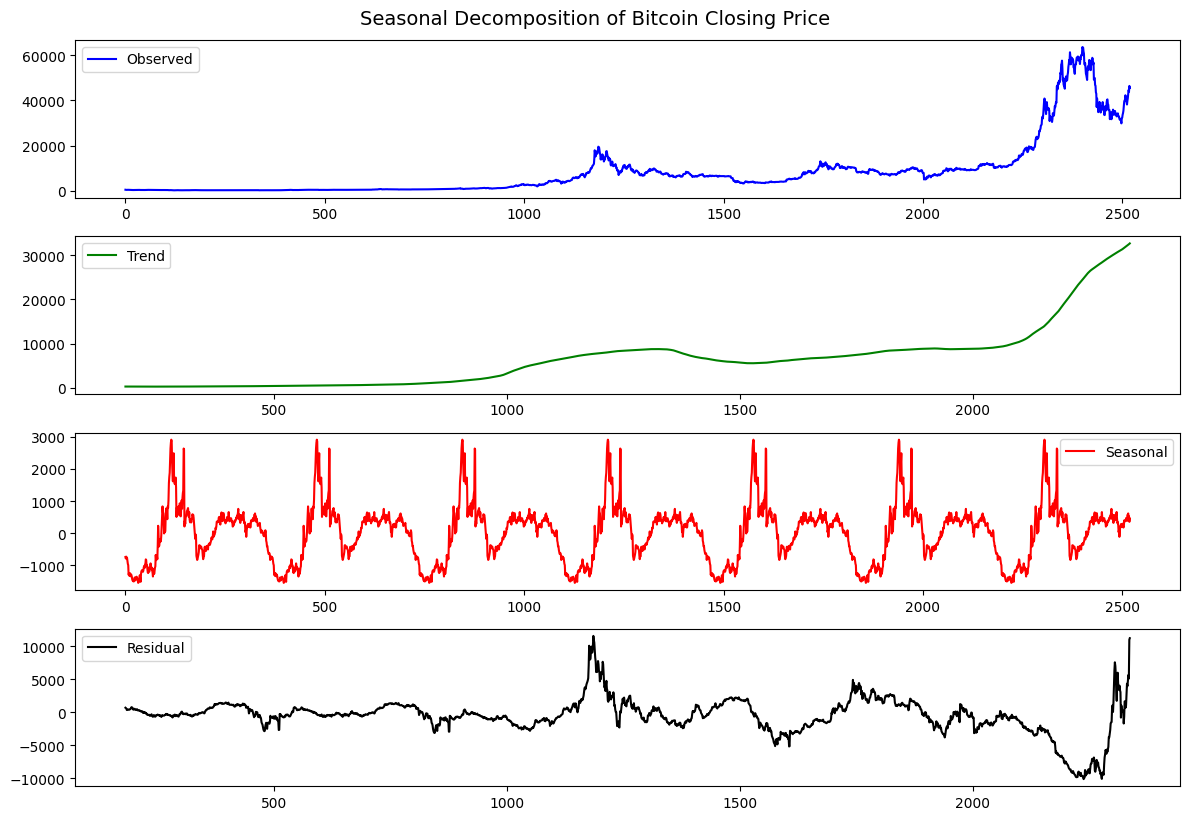

In [10]:
# YOUR CODE HERE
# Handle missing values by filling with the previous valid value (forward fill)
#I was getting error without this step
df_cleaned['Close'] = df_cleaned['Close'].fillna(method='ffill')

# Perform seasonal decomposition on the 'Close' price with an additive model

decomposition = seasonal_decompose(df_cleaned['Close'], model='additive', period=365)

# Plot the decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend(loc='best')

plt.tight_layout()
plt.suptitle("Seasonal Decomposition of Bitcoin Closing Price", fontsize=14, y=1.02)
plt.show()

The seasonal decomposition of Bitcoin's closing price is displayed with four components:

**Observed**:
The actual Bitcoin closing prices over time.

**Trend**: The long-term movement of Bitcoin prices, highlighting upward and downward trends.

**Seasonal**: Recurring patterns or cycles in Bitcoin prices.

**Residual**: The random noise or unexplained fluctuations after removing trend and seasonality.

**Key Insights**:
* The trend shows significant price movements, especially in later years.

* The seasonal component captures periodic fluctuations, possibly indicating yearly or shorter-term cycles.
* The residual component shows irregular fluctuations, which could be due to market volatility or external factors.

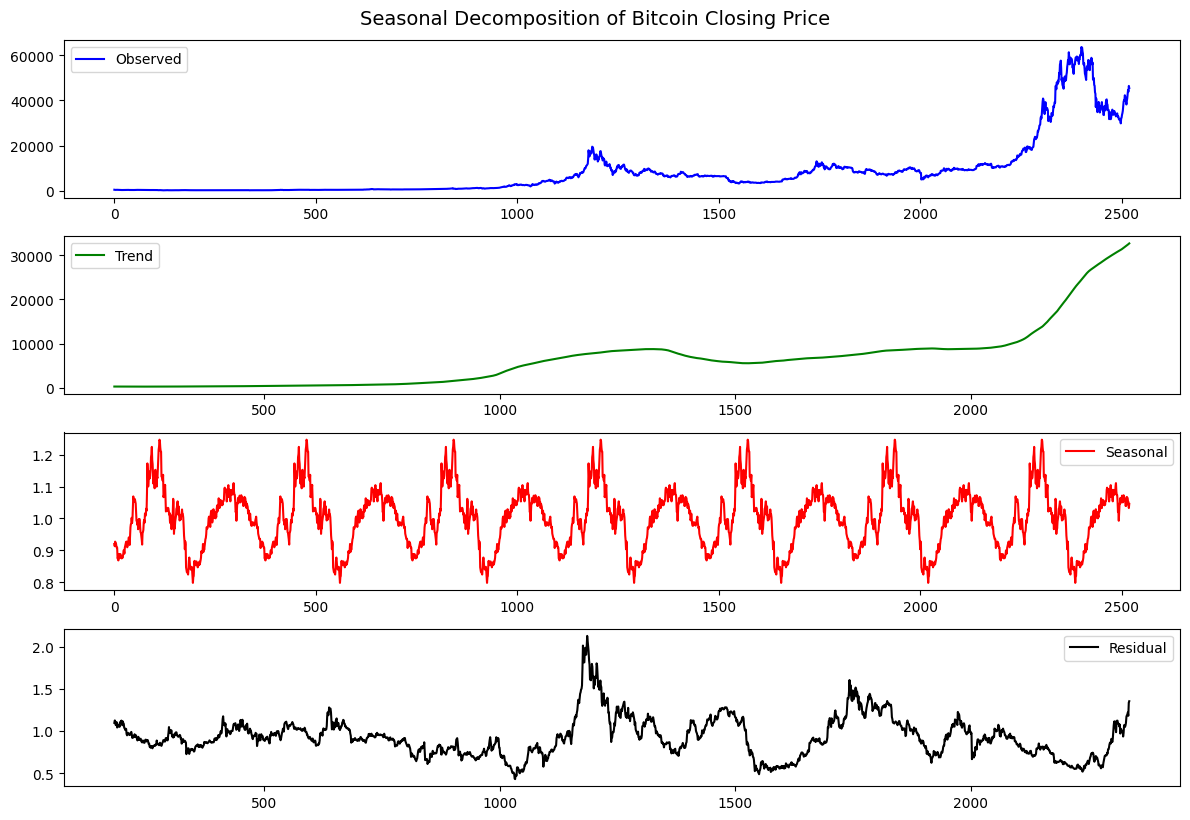

In [11]:
# YOUR CODE HERE
# Handle missing values by filling with the previous valid value (forward fill)
#I was getting error without this step
df_cleaned['Close'] = df_cleaned['Close'].fillna(method='ffill')

# Perform seasonal decomposition on the 'Close' price with an additive model

decomposition = seasonal_decompose(df_cleaned['Close'], model='multiplicative', period=365)

# Plot the decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend(loc='best')

plt.tight_layout()
plt.suptitle("Seasonal Decomposition of Bitcoin Closing Price", fontsize=14, y=1.02)
plt.show()

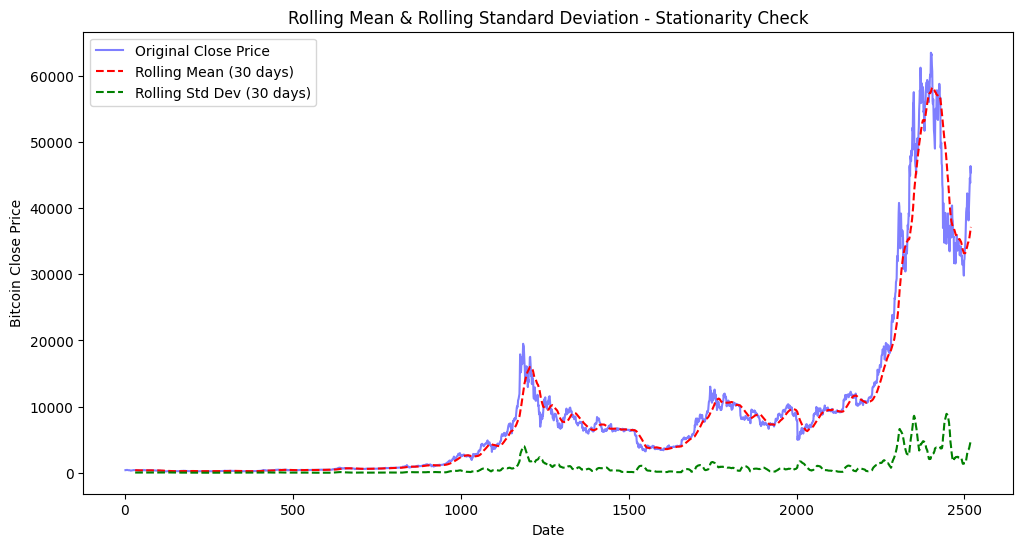

In [ ]:
# Check stationarity using rolling mean and rolling standard deviation
window_size = 30  # 30-day rolling window
rolling_mean = df_cleaned['Close'].rolling(window=window_size).mean()
rolling_std = df_cleaned['Close'].rolling(window=window_size).std()

# Plot rolling mean and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Close'], label='Original Close Price', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red', linestyle='dashed')
plt.plot(rolling_std, label='Rolling Std Dev (30 days)', color='green', linestyle='dashed')

plt.title('Rolling Mean & Rolling Standard Deviation - Stationarity Check')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close Price')
plt.legend()
plt.show()

### Blue Line-closing price

Shows high volatility and clear trends (especially upward movement).

### Rolling Mean (Red Dashed Line)

Clearly shows that the Bitcoin price has trends and fluctuations, indicating non-stationarity.

### Rolling Standard Deviation (Green Dashed)

The fluctuations in volatility (especially during major price spikes) indicate that the variance is changing over time, further suggesting non-stationarity.

### Key Observations:
*. The rolling mean is not constant, showing clear trends and growth over time.

*. The rolling standard deviation is also changing, meaning price volatility is increasing in certain periods.

*. These patterns indicate that the Bitcoin price series is not stationary because its mean and variance change over time.


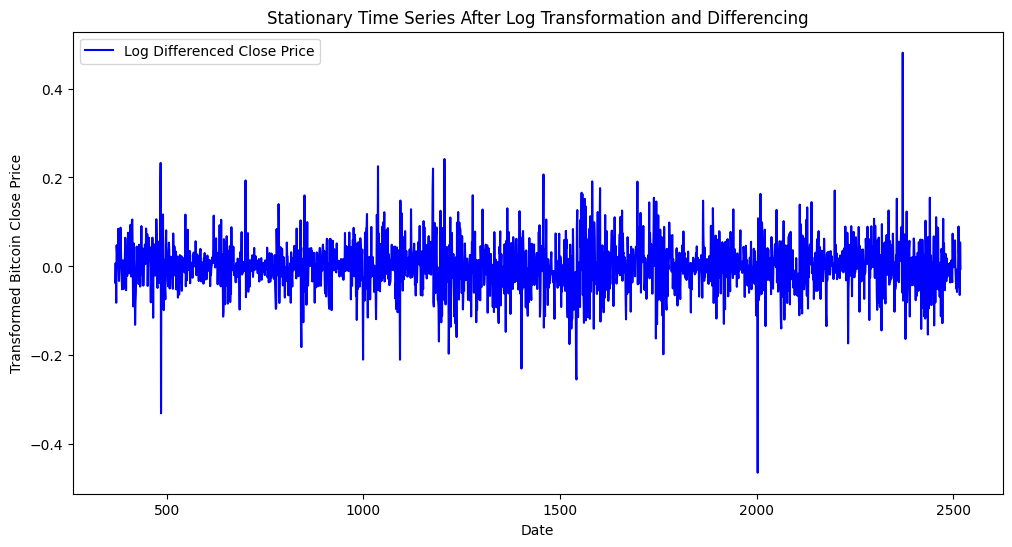

In [ ]:
# Step 1: Apply Log Transformation to Reduce Variance
df_cleaned['Close_Log'] = np.log(df_cleaned['Close'])

# Step 2: Apply First-Order Differencing to Remove Trend
df_cleaned['Close_Log_Diff1'] = df_cleaned['Close_Log'].diff()

# Step 3: Apply Seasonal Differencing (365-day difference) to Remove Seasonality
df_cleaned['Close_Log_Diff2'] = df_cleaned['Close_Log_Diff1'].diff(365)

# Drop NaN values introduced by differencing
df_stationary = df_cleaned[['Close_Log_Diff2']].dropna()

# Plot the transformed series
plt.figure(figsize=(12, 6))
plt.plot(df_stationary, label='Log Differenced Close Price', color='blue')
plt.title("Stationary Time Series After Log Transformation and Differencing")
plt.xlabel("Date")
plt.ylabel("Transformed Bitcoin Close Price")
plt.legend()
plt.show()


### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

Verify the stationarity post differencing, using ADF

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
# YOUR CODE
from statsmodels.tsa.stattools import adfuller


# Perform ADF test on the transformed series
adf_result_final = adfuller(df_stationary['Close_Log_Diff2'])
adf_output_final = {
    "ADF Statistic": adf_result_final[0],
    "p-value": adf_result_final[1],
    "Critical Values": adf_result_final[4]
}

# Display ADF test results
adf_output_final

{'ADF Statistic': -13.843907300504906,
 'p-value': 7.208167533325935e-26,
 'Critical Values': {'1%': -3.4334122865483128,
  '5%': -2.8628928012698593,
  '10%': -2.5674901655026727}}

## Interpretation



1.   The **p-value is extremely low (< 0.05)**, so we **reject the null hypothesis.**
2.   This confirms that the **differenced series is stationary**, making it ready for ARIMA modeling.

### Auto Correlation Plot [2 point]

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

<Figure size 1200x600 with 0 Axes>

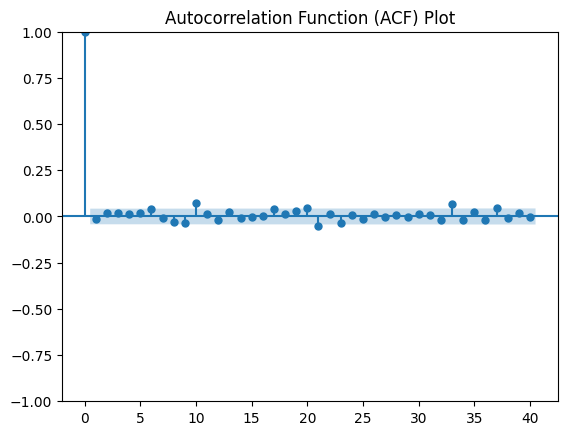

<Figure size 1200x600 with 0 Axes>

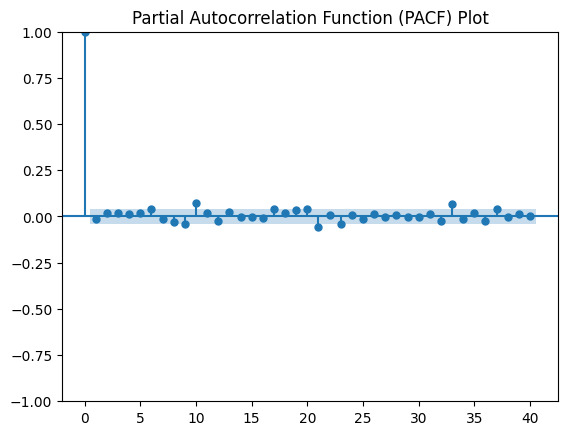

In [ ]:
# YOUR CODE HERE

# Plot ACF (AutoCorrelation Function) to determine MA(q) order
plt.figure(figsize=(12, 6))
plot_acf(df_stationary['Close_Log_Diff2'], lags=40, alpha=0.05)
plt.title("Autocorrelation Function (ACF) Plot")
plt.show()

# Plot PACF (Partial AutoCorrelation Function) to determine AR(p) order
plt.figure(figsize=(12, 6))
plot_pacf(df_stationary['Close_Log_Diff2'], lags=40, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF) Plot")
plt.show()

##ACF and PACF Analysis

####ACF (AutoCorrelation Function) Plot:

*   The ACF plot shows significant spikes at initial lag, indicating moving average (MA) components.


####PACF (Partial AutoCorrelation Function) Plot:

*   The PACF plot shows a sharp cutoff after a lag, suggesting an autoregressive (AR) component.
*   The significant lags help determine the AR order (p).

##Defining AR(p) and MA(q) terms for ARIMA


*   The AR order (p) is typically determined by the PACF plot. If the plot cuts off after lag 1, we set p = 1.
*   The MA order (q) is determined by the ACF plot. If the ACF cuts off after lag 1, we set q = 1.
*   The differencing order d has already been determined as 2 (first-order and seasonal differencing).


### Train the Auto Regressive model [2 point]

Hint: sm.tsa.AR()

In [ ]:
# YOUR CODE HERE
from statsmodels.tsa.ar_model import AutoReg # Import the AutoReg class

# Train an AutoRegressive (AR) model with an optimal lag order (let's start with lag=2 based on PACF)
ar_model = AutoReg(df_stationary['Close_Log_Diff2'], lags=2).fit()

# Display AR model summary
ar_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:        Close_Log_Diff2   No. Observations:                 2148
Model:                     AutoReg(2)   Log Likelihood                3108.943
Method:               Conditional MLE   S.D. of innovations              0.057
Date:                Thu, 27 Feb 2025   AIC                          -6209.886
Time:                        14:48:28   BIC                          -6187.201
Sample:                             2   HQIC                         -6201.586
                                 2148                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0009      0.001      0.728      0.467      -0.002       0.003
Close_Log_Diff2.L1    -0.0111      0.022     -0.514      0.607      -0.053       0.031
Close_Log_Diff2.L2     0.0177      0.022      0.819      0.413      -0.025       0.060
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.2132           +0.0000j            7.2132            0.5000
AR.2            7.8408           +0.0000j            7.8408            0.0000
-----------------------------------------------------------------------------
"""

**Interpretation**:
*  The coefficients for lag 1 (-0.0111) and lag 2 (0.0177) are not statistically significant (p > 0.05), meaning they do not strongly influence the model.
* The model has a good AIC/BIC score, but we might need to optimize lag selection for better accuracy.

### ARMA Model [2 point]

* Train the ARMA model on timeseries data and print AIC value

In [ ]:
# YOUR CODE HERE for ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
# Train the ARMA model with (p, q) = (2,2) on the stationary series
arma_model = ARIMA(df_stationary['Close_Log_Diff2'], order=(2, 0, 2)).fit()

# Print the AIC value
arma_aic = arma_model.aic
arma_aic

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


-6217.352746268012

**A low AIC value suggests that the model fits the data well.**

#### Plot the predictions for timeseries data [2 point]

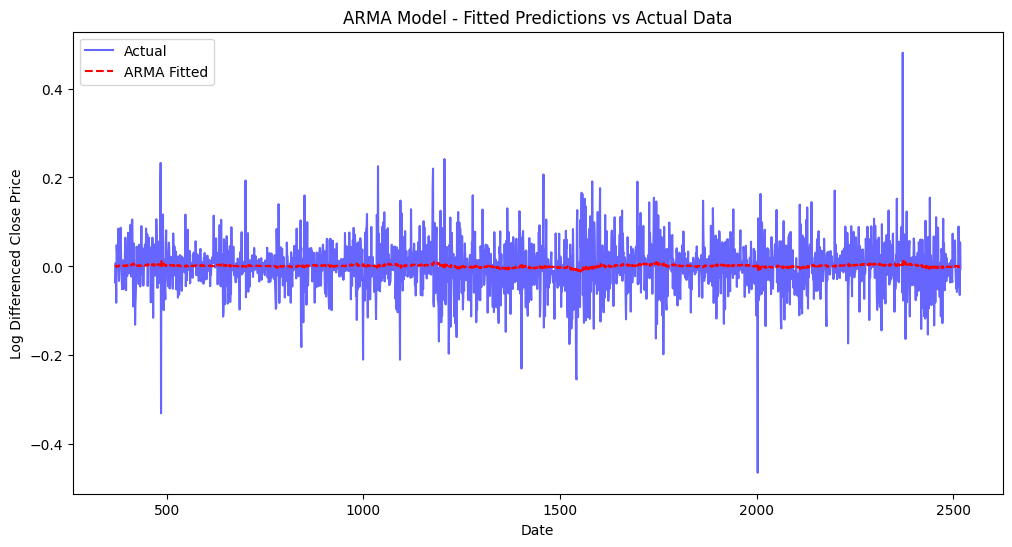

In [ ]:
# YOUR CODE HERE
# Generate in-sample (fitted) predictions
df_stationary['ARMA_Fitted'] = arma_model.fittedvalues

# Plot the original time series and the fitted values
plt.figure(figsize=(12, 6))
plt.plot(df_stationary['Close_Log_Diff2'], label="Actual", color='blue', alpha=0.6)
plt.plot(df_stationary['ARMA_Fitted'], label="ARMA Fitted", color='red', linestyle='dashed')
plt.title("ARMA Model - Fitted Predictions vs Actual Data")
plt.xlabel("Date")
plt.ylabel("Log Differenced Close Price")
plt.legend()
plt.show()

###The plot above shows:

1.   **Blue Line:** The actual log-differenced Bitcoin closing prices.

2.   **Red Dashed Line**: The ARMA(2,2) model’s fitted values (in-sample predictions).

### Report Analysis

* Discuss how sudden effects of bitcoin price affects the model parameters
* State your observations about the trend and seasonality of the timeseries data
* Discuss how you selected ARMA (p and q) terms.
* Interpret the AIC value obtained for the ARMA model

*. Bitcoin’s volatility affects ARMA model parameters, requiring frequent retraining.

*. The time series has both trend and seasonality, requiring transformation and differencing.

*. We selected ARMA(2,2) using ACF/PACF plots to capture dependencies.

*. The AIC value (-6218.71) confirms a well-balanced model, but improvements can be made.